In [4]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap
from pixell import enplot

import data.kfilter.kfilter_share as steve

The function definition here is

```python
def get_map_kx_ky_filtered_pyfftw(m,d_th,kx_cut,kx_cut_apo,ky_cut,ky_cut_apo,unpixwin=0,zero_pad=False):
    """ given input m (I,Q,U) apply a 2d fourier mask with ky_cut and apodization over ky_cut_apo, then return the filtered map
    uses pyfftw for fft's
    """
```

Let's write some test parameters.

In [6]:
# from run.py
kx = 90
ky = 50
kx_apo = 0
ky_apo = 0
unpixwin = 0 # we will avoid this for now, should only matter for small scales?
d_th = 1/120.

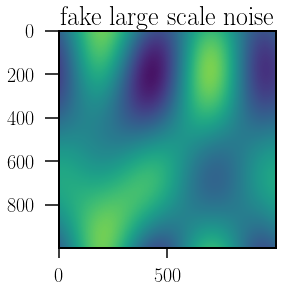

In [7]:
shape,wcs = enmap.geometry(shape=(1000,1000),
                           res=np.deg2rad(d_th),pos=(0,0))

# generate large scale noise
ps = ells = np.arange(0,4000,1)
ps = np.ones_like(ells)
rand_map = enmap.rand_map(shape,wcs, cov=ps[None,None])

kmap = enmap.fft(rand_map)
ly, lx = enmap.lmap(kmap.shape, kmap.wcs)
kmap[ np.abs(lx) > kx ] = 0.0
kmap[ np.abs(ly) > ky ] = 0.0
test_map = enmap.ifft(kmap).real

plt.title('fake large scale noise')
plt.imshow(test_map, vmin=-80, vmax=80)

Let's take a look at the k-space properties by converting back (also make sure we can indeed convert back!).

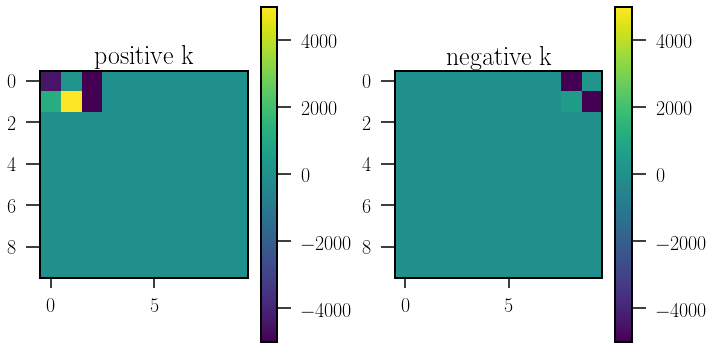

In [10]:
test_map_k = enmap.fft(test_map).real

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].set_title('positive k')
im0 = axes[0].imshow( test_map_k[0:10, 0:10].real, vmin=-5000, vmax=5000 )
fig.colorbar(im0, ax=axes[0])
axes[1].set_title('negative k')
im1 = axes[1].imshow( test_map_k[0:10, -10:].real, vmin=-5000, vmax=5000 )
fig.colorbar(im1, ax=axes[1])
plt.tight_layout()

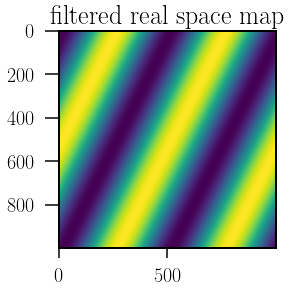

In [12]:
filtered = enmap.samewcs(
    steve.get_map_kx_ky_filtered_pyfftw(m=test_map,
                                    d_th=d_th,
                                    kx_cut=kx,kx_cut_apo=kx_apo,
                                    ky_cut=ky,ky_cut_apo=ky_apo,
                                    unpixwin=unpixwin, zero_pad=False),
    test_map)

plt.title('steve filtered real space map')
plt.imshow(filtered)

Now let's try it with pixell functions.

In [15]:
def filter_map(m, kx, ky):
    k_r0 = enmap.fft(m)
    ly, lx = enmap.lmap(k_r0.shape, k_r0.wcs)
    k_r0[ (np.abs(lx) <= kx ) ] = 0.0
    k_r0[ (np.abs(ly) <= ky ) ] = 0.0
    r0_diy = enmap.ifft(k_r0)
    return r0_diy.real

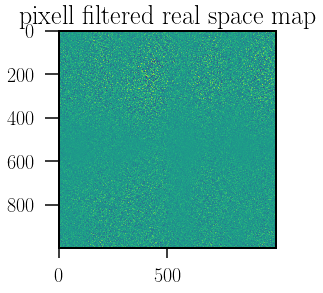

In [17]:
diy_filtered = filter_map(test_map, kx, ky)

plt.title('pixell filtered real space map')
plt.imshow(diy_filtered)